# Explanatory Data Analisys - GoogleAnalytics Revenue Prediction Challenge

## Code Approach

This code is the summary of my kernel posted on kaggle, over the Google Analytics Revenue Prediction Challenge: 
https://www.kaggle.com/wesleyjr01/google-analytics-challenge-data-analisys

The objective of this code's is to give some data analysis and intuition around the Google Analytics Customer Revenue Prediction dataset. No Machine Learning model will be presented here, the first step to make a good model is to understand the data, and that's why we are here! Also, as a market segmentation-like problem, we should know very well our public tendencies.


## Competition dataset

In this competition, as in many others we are given two datasets:
* train.csv
* test.csv

Basically we are asked to use the data in train.csv to build a model and predict the Customer Revenue about the test.csv dataset, as better explained in the official challenge post Challenge Description(https://www.kaggle.com/c/ga-customer-revenue-prediction).


## Reshaping the given dataset

As mentioned in the challenge description, some fields of the datasets train.csv and test.csv are in json format, and for better data manipulation with DataFrames, we should make some type conversions first. For this task, we already have a pretty nice kernel(https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook) built by Julián Peller(https://www.kaggle.com/julian3833).

In [33]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

def load_df(csv_path='C:/Google Analytics Customer Revenue Prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

df_train = load_df()
df_test = load_df("C:/Google Analytics Customer Revenue Prediction/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [34]:
#Lets have a look at the data
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


## Data Analisys

One very important observation we have to keep in mind is that our visitors'Ids are unique, but the Id's rows in the datasets are not unique, as stated in the Challange Data Description.
Both train.csv and test.csv contain the columns listed under Data Fields. Each row in the dataset is one visit to the store. Because we are predicting the log of the total revenue per user, be aware that not all rows in test.csv will correspond to a row in the submission, but all unique fullVisitorIds will correspond to a row in the submission.

In [35]:
#Lets check this out
df_train.columns
print('Is there more than one transaction by VisitorId in train dataset?',
      len(df_train['fullVisitorId'])!=df_train['fullVisitorId'].nunique())
print('Is there more than one transaction by VisitorId in test dataset?',
      len(df_test['fullVisitorId'])!=df_test['fullVisitorId'].nunique())

Is there more than one transaction by VisitorId in train dataset? True
Is there more than one transaction by VisitorId in test dataset? True


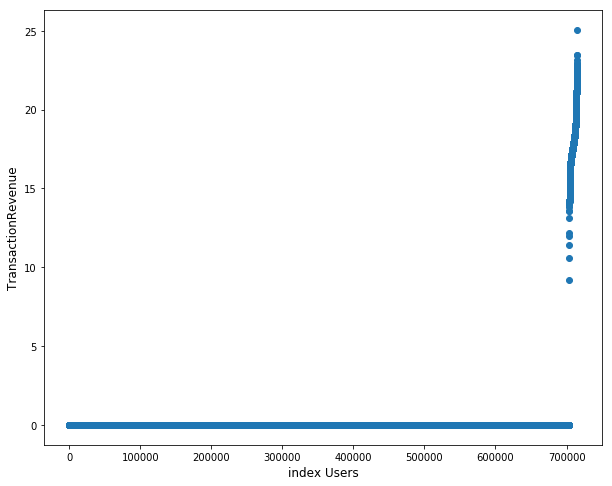

In [36]:
#Lets see how the transaction revenues behave among all unique users
import matplotlib.pyplot as plt
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].astype('float')
gdf = df_train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
plt.figure(figsize=(10,8))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"])))
plt.xlabel('index Users', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

By this plot above we can conclude that the majority of the TransactionRevenue comes from a very little portion of costumers.
Therefore, the marketing teams must direct carefully their effor on investments.

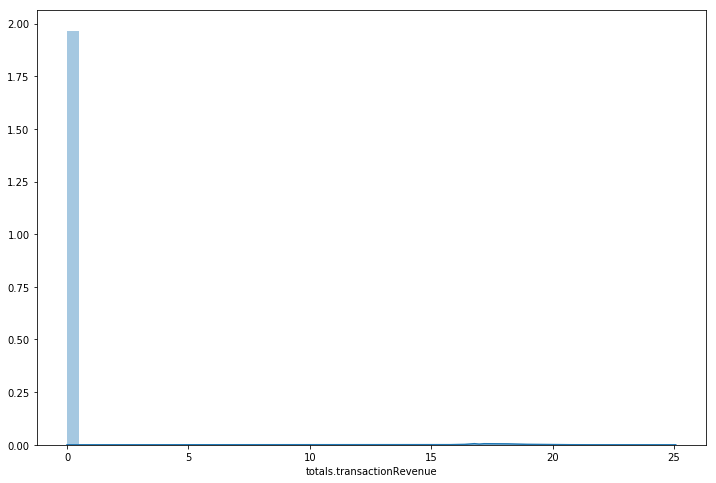

In [37]:
#Lets see a distribution plot of the target variable to confirm our hypothesis
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(np.log1p(gdf["totals.transactionRevenue"]),ax=ax)

As expected, the majority of users don't contribute to the revenue at all.

In [38]:
print('\n',pd.notnull(df_train["totals.transactionRevenue"]).sum(),
' Non-null revenue Instances ocurred, which represent',
 round(100*(pd.notnull(df_train["totals.transactionRevenue"]).sum()/len(df_train)),2),'% of all Instances')


 11515  Non-null revenue Instances ocurred, which represent 1.27 % of all Instances


In [39]:
print('\n',gdf["totals.transactionRevenue"][gdf["totals.transactionRevenue"]>0].count(),
' Customers contribute with non-zero revenue which is equivalent to',
round(100*(gdf["totals.transactionRevenue"][gdf["totals.transactionRevenue"]>0].count()/len(gdf)),2),'% of all Customers')


 9996  Customers contribute with non-zero revenue which is equivalent to 1.4 % of all Customers


## Dropping columns with constant values

Some of the features imported in the json-csv process have only one unique value, which doesn't give us any information, and it would be a problem for any MachineLearning model. So we should just drop them.

In [40]:
dropcols = [c for c in df_train.columns if df_train[c].nunique()==1]
dropcols_test = [c for c in df_test.columns if df_test[c].nunique()==1]
df_train = df_train.drop(dropcols,axis=1)
df_test = df_test.drop(dropcols_test,axis=1)

## Build some percentage features

It is usefull to build some extra features in order to have the percentage information, for example the % of instances in relation of a specific web browser in relation to all instances accounted for all web browsers:

In [41]:
#Definition of the aggregation funtion, that we will use to build some % features
def aggregations(feature):
    df = df_train.groupby(feature)['totals.transactionRevenue'].agg(['size', 'count'])
    df.columns = ["count of instances", "count of non-zero revenue"]
    df['percent of instances[%]'] = (df['count of instances']*100)/df['count of instances'].sum()
    df['percent of non-zero revenue[%]'] = (df['count of non-zero revenue']*100)/df['count of non-zero revenue'].sum()
    df = df.sort_values(by="percent of non-zero revenue[%]", ascending=False)
    return df

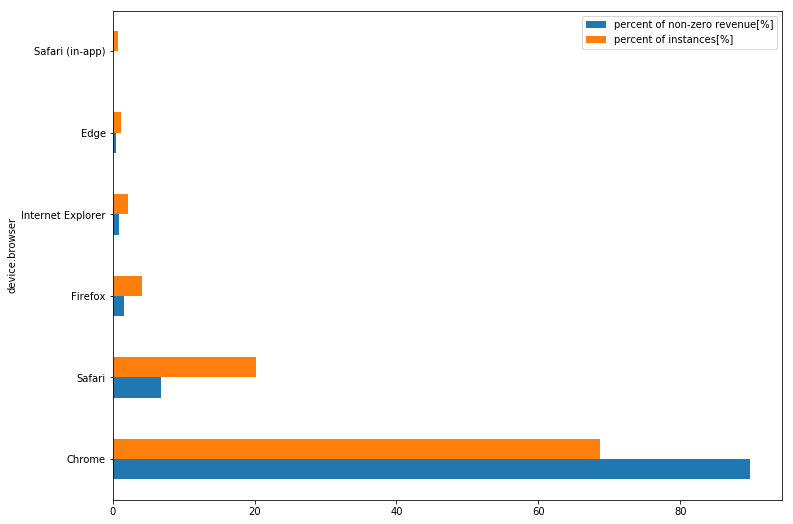

In [42]:
# Device Browser Analisys:
cnt_srs = aggregations('device.browser')
top_rev = cnt_srs["percent of non-zero revenue[%]"].nunique()
cnt_srs[:6].plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

It is pretty clear that the majority of instances and non-zero revenues comes from chromes users.

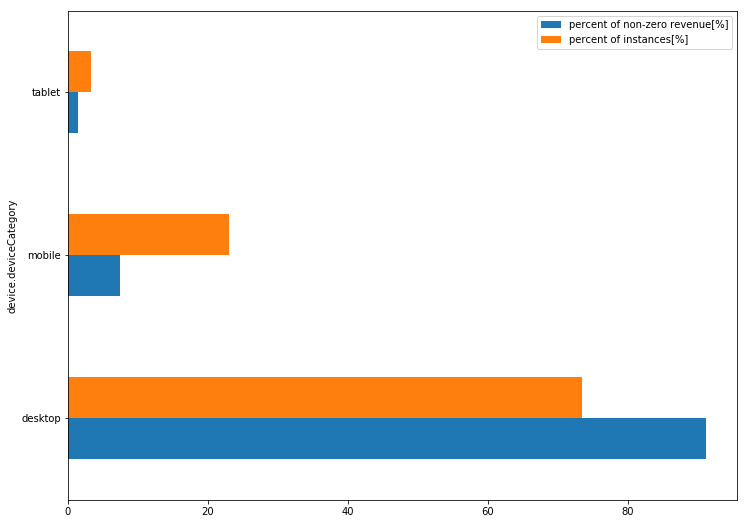

In [43]:
# Device Category (Desktop,...)
cnt_cat = aggregations('device.deviceCategory')
cnt_cat.plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

On the device category front, desktop seem to have higher percentage of non-zero revenue counts compared to mobile devices.

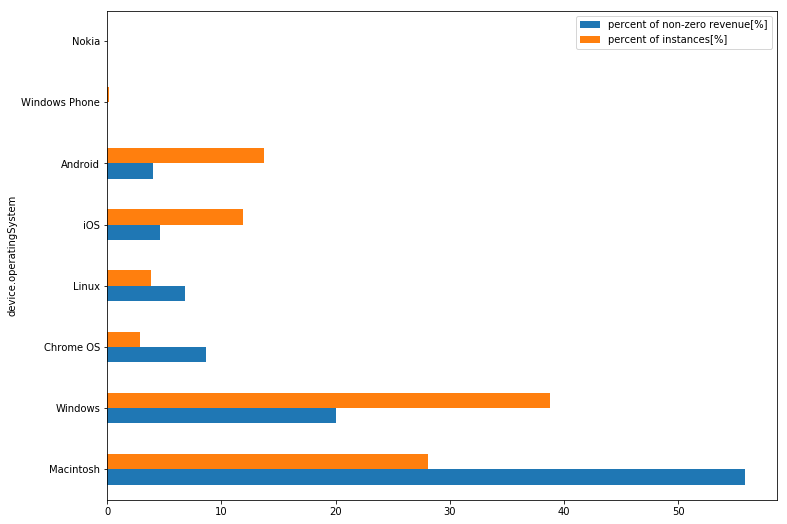

In [44]:
# Device Operating System (Windows,...)
cnt_os = aggregations('device.operatingSystem')
cnt_os[:8].plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

In device operating system, although the number of counts is more from windows, the number of counts where revenue is not zero is more for Macintosh.

### Date Information

Lets split the information in Years/Months/Days and to use of the date information.

In [45]:
df_train['year']= df_train['date'].astype(str).str[:4]
df_test['year']= df_test['date'].astype(str).str[:4]
df_train['month']= df_train['date'].astype(str).str[4:6]
df_test['month']= df_test['date'].astype(str).str[4:6]
df_train['day']= df_train['date'].astype(str).str[6:8]
df_test['day']= df_test['date'].astype(str).str[6:8]
df_train.drop('date',axis=1,inplace=True)
df_test.drop('date',axis=1,inplace=True)

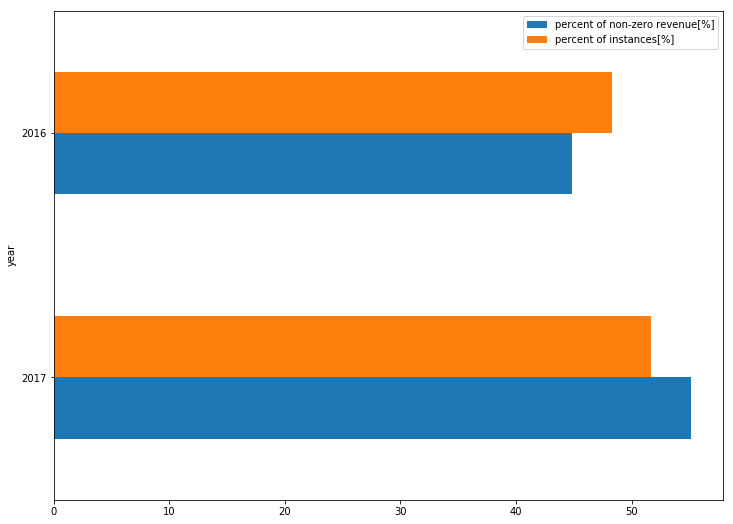

In [46]:
# Year Analisys
cnt_y = aggregations('year')
cnt_y.plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

Slight differences beetween years, probably not worth to keep this information on dataset

In [47]:
df_train.drop('year',axis=1,inplace=True)
df_test.drop('year',axis=1,inplace=True)

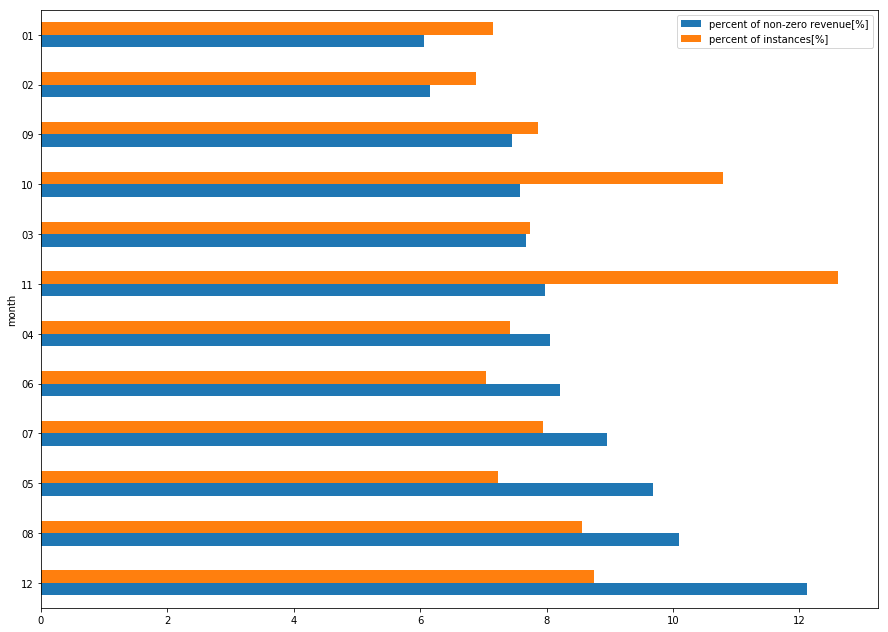

In [48]:
# Months Analisys
cnt_m = aggregations('month')
cnt_m.plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(15,11))

Looks like in Dezember people are more likely to buy, most likely because of New Year parties like Christmas. An interesting observation here is that at November there is a peak of instances, proably because people are researching what they should buy in December.

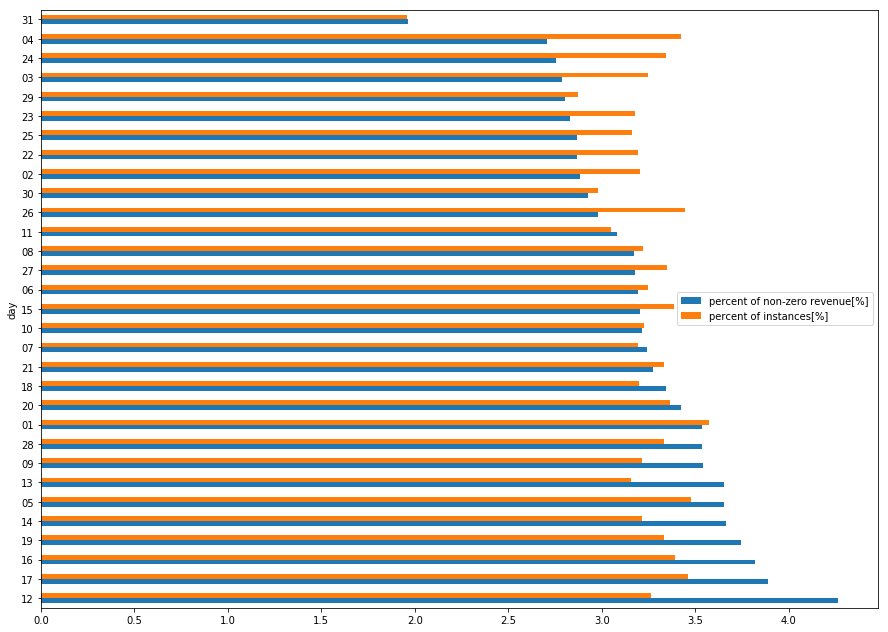

In [49]:
# Days of the Month Analisys
cnt_d = aggregations('day')
cnt_d.plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(15,11))


Looks like every 12th day of the month ppl are more likely to buy.

### Regions Information:

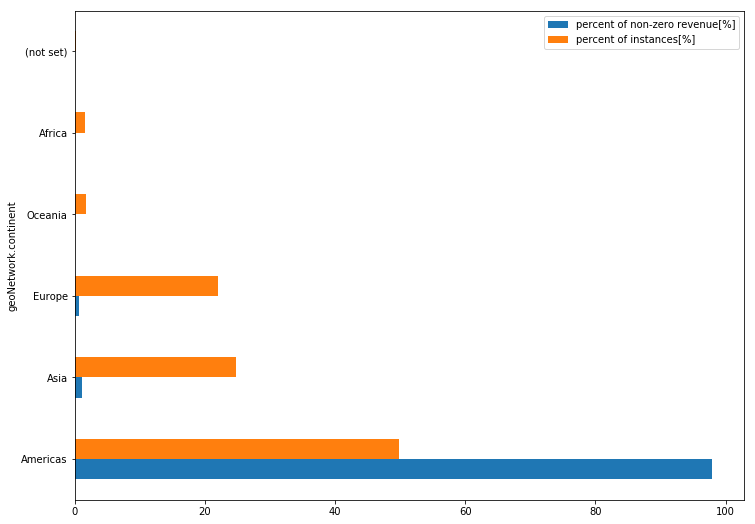

In [50]:
# Continent Analysis
cnt_con = aggregations('geoNetwork.continent')
cnt_con.plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

Clearly the Americas englobe the absolut majority of revenue. I was expecting the Europe to go on second, but it is behind Asia.

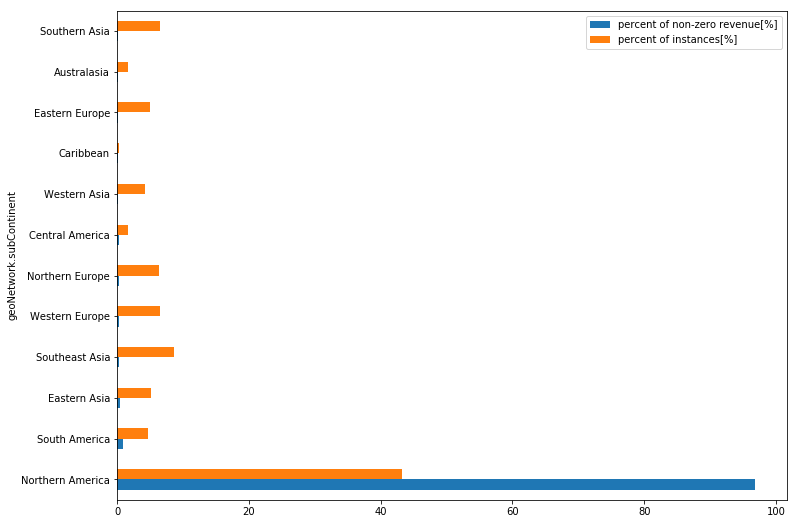

In [51]:
# SubContinent Analysis
cnt_scon = aggregations('geoNetwork.subContinent')
cnt_scon[:12].plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

Again, the absolute majority of revenue comes from North America, followed by South America, Eastern Asia and South Asia. From forth position on there is almost no representativity.

### Traffic Source Analisys:

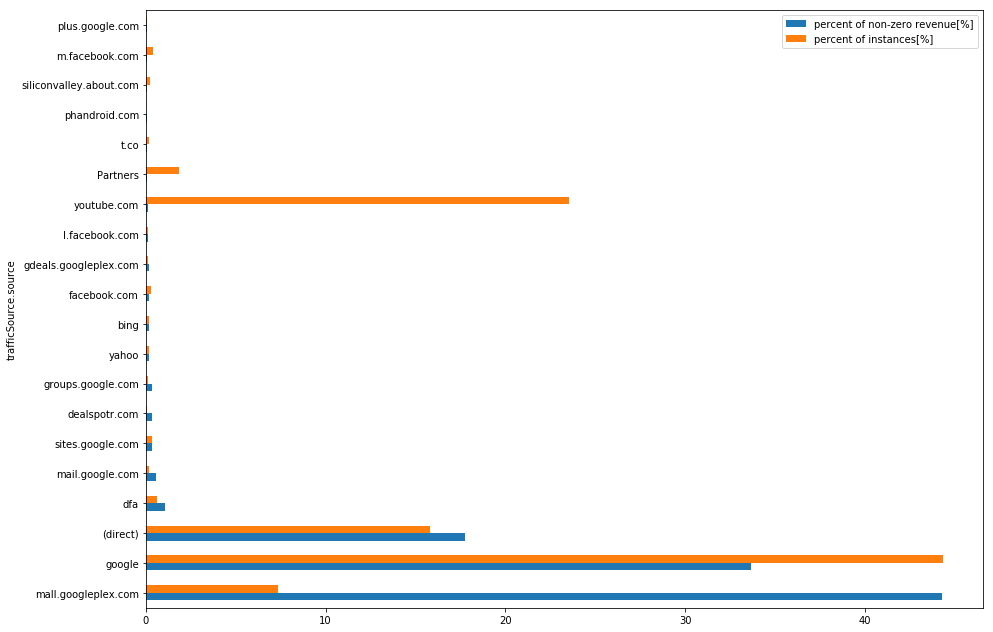

In [52]:
#Traffic Source
cnt_ts = aggregations('trafficSource.source')
cnt_ts[:20].plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(15,11))

Google Search and Google Sales plataforms are domaining the counts and non-zero revenue.It is interesting to see that Youtube has a lot of counts, but has a very low non-zero ratio revenue.

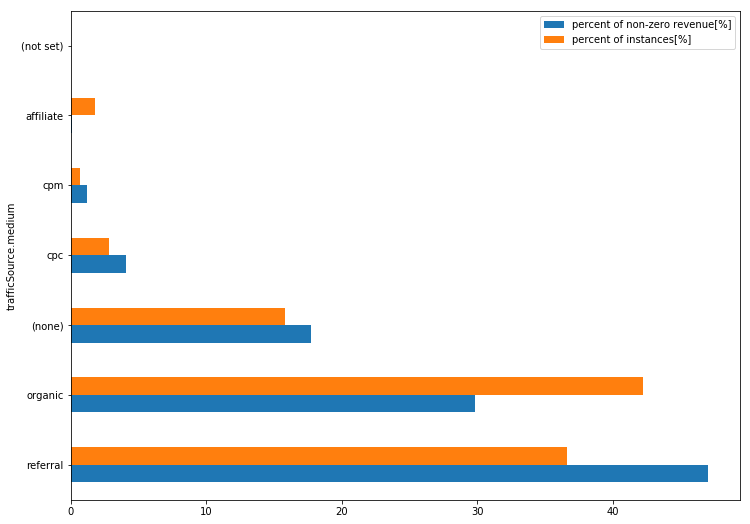

In [53]:
#Traffic Source Medium:
cnt_tsm = aggregations('trafficSource.medium')
cnt_tsm.plot.barh(y=['percent of non-zero revenue[%]','percent of instances[%]'], rot=0,figsize=(12,9))

Even though "organic users" have more counts overall, the counts from referral were converted into non-zero revenue in a higher ratio. This shows us the big influence that referral has in sales.

### Visitor Information Analisys:

Text(0,0.5,'count of non-zero revenue')

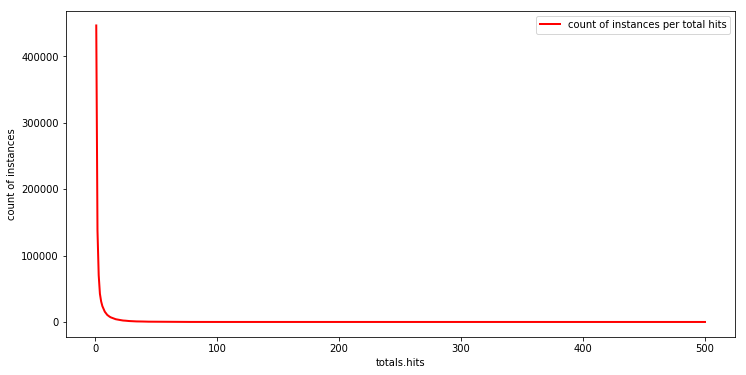

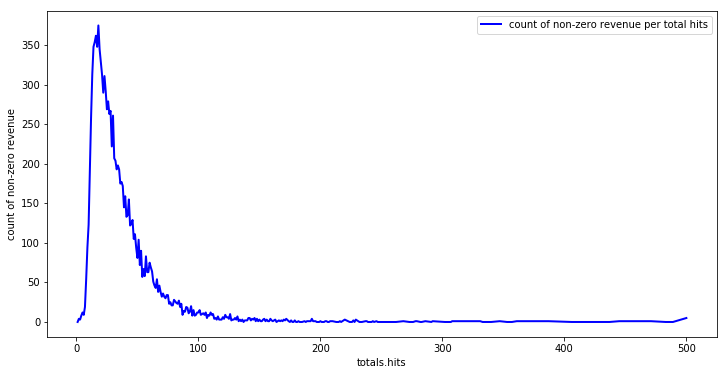

In [54]:
#Hits
cnt_hit = aggregations('totals.hits').reset_index()
cnt_hit['totals.hits'] = cnt_hit['totals.hits'].astype(int)
cnt_hit.sort_values(by=['totals.hits'],inplace=True)
cnt_hit.set_index('totals.hits',inplace=True)
plt.figure(1,figsize=(12,6))
plt.plot(cnt_hit.index,cnt_hit['count of instances'],'r',
         markersize=4,linewidth=2,label='count of instances per total hits')
plt.legend()
plt.xlabel('totals.hits')
plt.ylabel('count of instances')

plt.figure(2,figsize=(12,6))
plt.plot(cnt_hit.index,cnt_hit['count of non-zero revenue'],'b',
         markersize=4,linewidth=2,label='count of non-zero revenue per total hits')
plt.legend()
plt.xlabel('totals.hits')
plt.ylabel('count of non-zero revenue')

We can see that at low number of hits we have a low number of non-zero revenues, but as we increse the number of hits we get more non-zero revenues, reaching its peak at around hits=25, and then decreasing the number of non-zero revenues.

Text(0,0.5,'count of instances')

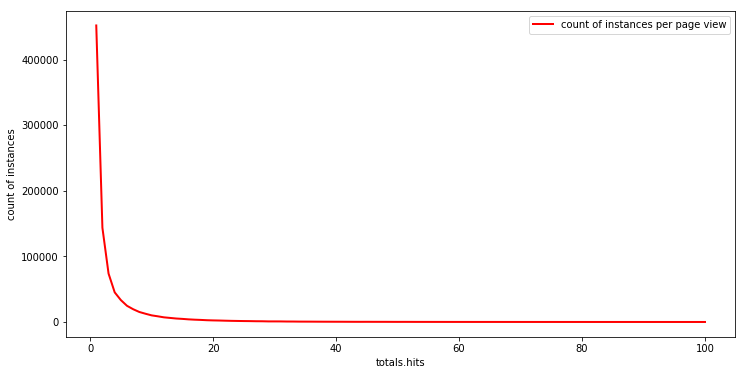

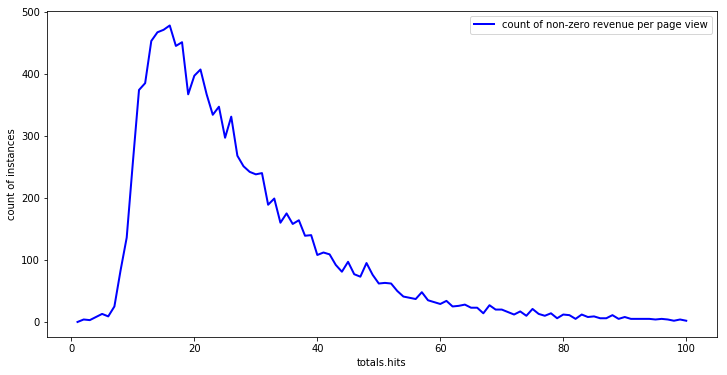

In [55]:
#PageViews
cnt_pv = aggregations('totals.pageviews').reset_index()
cnt_pv['totals.pageviews'] = cnt_pv['totals.pageviews'].astype(int)
cnt_pv.sort_values(by=['totals.pageviews'],inplace=True)
cnt_pv.set_index('totals.pageviews',inplace=True)

cnt_pv.sort_index(inplace=True)
plt.figure(3,figsize=(12,6))
plt.plot(cnt_pv.index[:100],cnt_pv['count of instances'][:100],'r',
         markersize=4,linewidth=2,label='count of instances per page view')
plt.legend()
plt.xlabel('totals.hits')
plt.ylabel('count of instances')

plt.figure(4,figsize=(12,6))
plt.plot(cnt_pv.index[:100],cnt_pv['count of non-zero revenue'][:100],'b',
         markersize=4,linewidth=2,label='count of non-zero revenue per page view')
plt.legend()
plt.xlabel('totals.hits')
plt.ylabel('count of instances')

So we have a very similar behaviour between totals.hits and totals.pageviews in relation to both instances and non-zero revenues.Most of users make very little instances, but the non-zero revenues comes users that acess the google plataform more frenquently, around 20 times.

### Last Considerations:

Before actually start building a ML model, although now we have some good insights about our data, we still need to deal with missing data, clean the data properlly by dropping some columns and adding some others by feature engineering. So before I end this EDA let's see the percentage of the missing data that we have on our left features:

In [56]:
#Missing Data on Train Dataset
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
trafficSource.adContent,892707,0.987887
totals.transactionRevenue,892138,0.987257
trafficSource.adwordsClickInfo.adNetworkType,882193,0.976252
trafficSource.adwordsClickInfo.slot,882193,0.976252
trafficSource.adwordsClickInfo.page,882193,0.976252
trafficSource.adwordsClickInfo.gclId,882092,0.976140
trafficSource.referralPath,572712,0.633774
trafficSource.keyword,502929,0.556551
totals.pageviews,100,0.000111
visitNumber,0,0.000000


So there are many features with more than 90% of missing data, so we should look carefully at them and decide wheter to Imput this data or drop them.

### That's all for now!

That's all for this EDA, soon I will post a Machine Learning code for this challenge aswell!